<a href="https://colab.research.google.com/github/MichelaMarini/MATH-6373-PyTorch-tutorial/blob/main/Image_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define a function to add salt and pepper noise to images
def add_salt_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    """
    Add salt and pepper noise to the input image.

    Args:
        image (Tensor): Input image tensor of shape (C, H, W).
        salt_prob (float): Probability of adding salt noise.
        pepper_prob (float): Probability of adding pepper noise.

    Returns:
        Tensor: Noisy image tensor of the same shape as the input image.
    """
    # Convert image to NumPy array
    image_np = image.numpy()

    # Generate random noise mask
    salt_mask = np.random.random(image_np.shape[:2]) < salt_prob
    pepper_mask = np.random.random(image_np.shape[:2]) < pepper_prob

    # Add salt noise
    image_np[salt_mask] = 1.0

    # Add pepper noise
    image_np[pepper_mask] = 0.0

    # Convert back to tensor and return
    return torch.from_numpy(image_np)

# Define transforms for MNIST dataset (without adding noise)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download MNIST train and test datasets without adding noise
original_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
original_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create separate lists for noisy images and original images
noisy_images = [add_salt_pepper_noise(image) for image, _ in original_train_dataset]
original_images = [image.clone() for image, _ in original_train_dataset]

# Combine the lists into a list of tuples
train_dataset = list(zip(noisy_images, original_images))


# Create separate lists for noisy images and original images
noisy_images_test = [add_salt_pepper_noise(image) for image, _ in original_test_dataset]
original_images_test = [image.clone() for image, _ in original_test_dataset]

# Combine the lists into a list of tuples
val_dataset = list(zip(noisy_images_test[:-9], original_images_test[:-9]))
# Combine the lists into a list of tuples
val_dataset = list(zip(noisy_images_test[:-9], original_images_test[:-9]))
# Combine the lists into a list of tuples
test_dataset = list(zip(noisy_images_test[-9:], original_images_test[-9:]))



# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 143344749.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37215266.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49452916.00it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21623755.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



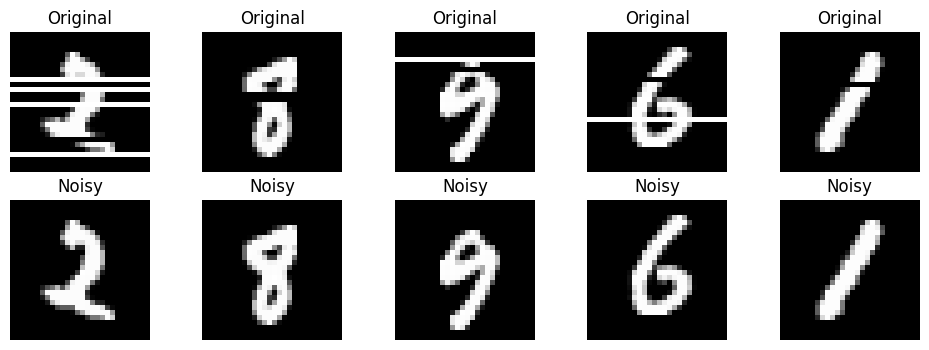

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images
def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    for i in range(num_images):
        original_image = images[i].squeeze().numpy()
        noisy_image = labels[i].squeeze().numpy()

        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(noisy_image, cmap='gray')
        axes[1, i].set_title("Noisy")
        axes[1, i].axis('off')
    plt.show()

# Get a batch of images from the train loader
images, labels = next(iter(train_loader))

# Plot original and noisy images
plot_images(images, labels)




In [4]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x = self.maxpool(x1)
        x = self.decoder(x)
        return x

# Initialize UNet model
# Define input and output channels
in_channels = 1  # For gray scale images
out_channels = 1  # Same as input for image restoration tasks

# Initialize the model
model = UNet(in_channels, out_channels)

# Print the model architecture
print(model)


UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (5): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = nn.MSELoss().to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
best_val_loss = float('inf')
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # Average training loss
    train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    # Average validation loss
    val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Save the model with the best validation accuracy
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

print("Training complete.")


Epoch 1/10, Train Loss: 0.01056902342364192, Val Loss: 0.00236099060228576
Epoch 2/10, Train Loss: 0.0020008209485560657, Val Loss: 0.0016931321143995128
Epoch 3/10, Train Loss: 0.0015447812185312312, Val Loss: 0.0012966865588275238
Epoch 4/10, Train Loss: 0.0012977978277330597, Val Loss: 0.0011415964526150586
Epoch 5/10, Train Loss: 0.0011523768140003084, Val Loss: 0.0010745959104533846
Epoch 6/10, Train Loss: 0.0010607340227191647, Val Loss: 0.0010047562990047056
Epoch 7/10, Train Loss: 0.0009904062147562702, Val Loss: 0.0009978855854620315
Epoch 8/10, Train Loss: 0.0009313495555892587, Val Loss: 0.0008985105403459882
Epoch 9/10, Train Loss: 0.0008872694278756777, Val Loss: 0.0008918560096889081
Epoch 10/10, Train Loss: 0.0008463691901105146, Val Loss: 0.0007727755478314534
Training complete.


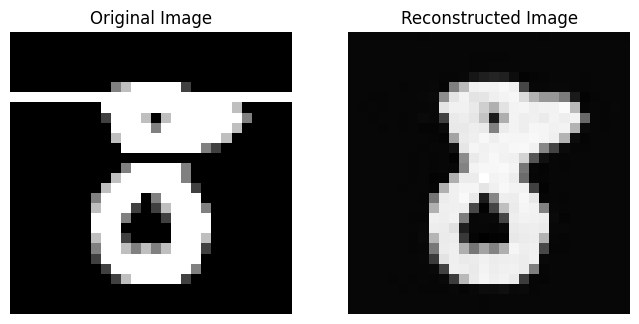

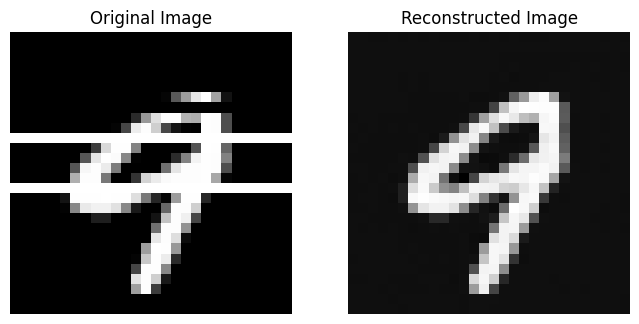

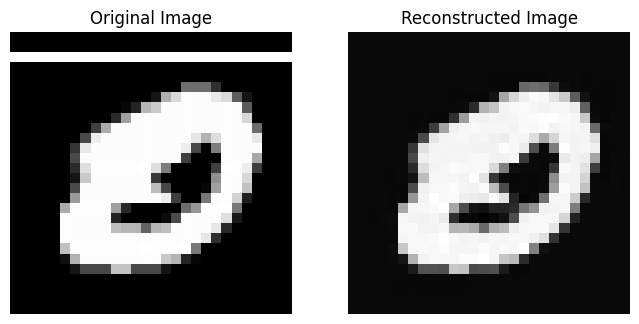

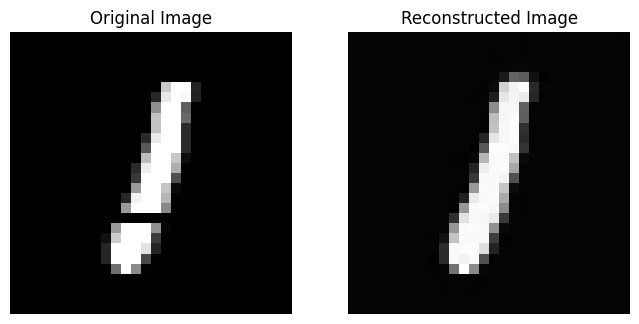

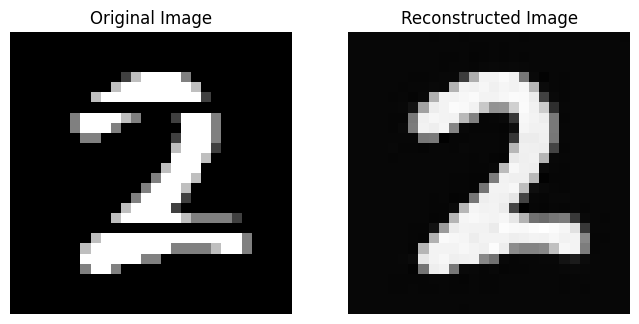

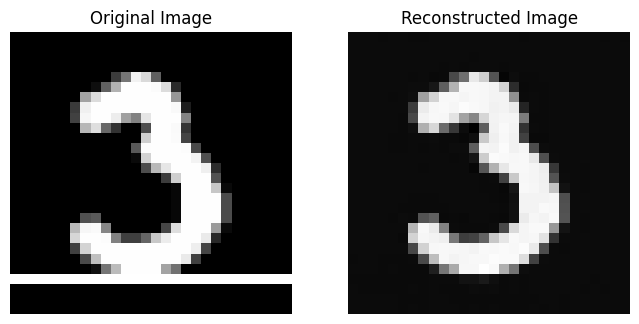

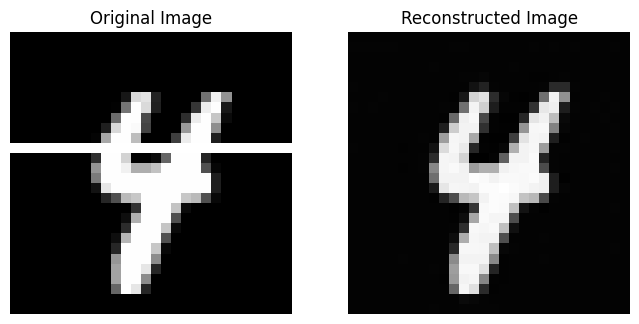

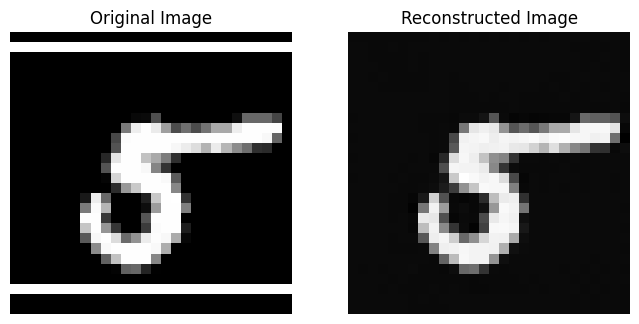

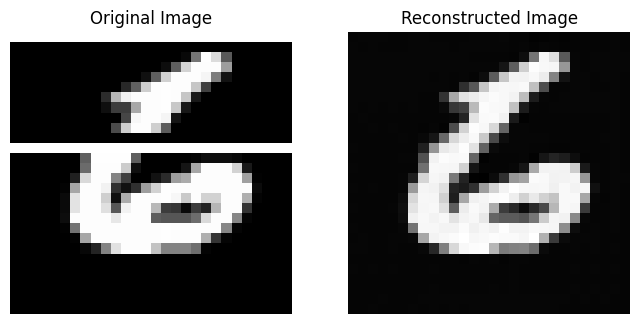

Reconstruction of test images complete.


In [6]:
import matplotlib.pyplot as plt

# Test the model on 10 images from the validation set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        for i in range(outputs.size(0)):
            # Plot original and reconstructed images side by side
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            original_image = images[i].cpu().squeeze().numpy()
            reconstructed_image = outputs[i].cpu().squeeze().numpy()

            axes[0].imshow(original_image, cmap='gray')
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            axes[1].imshow(reconstructed_image, cmap='gray')
            axes[1].set_title("Reconstructed Image")
            axes[1].axis('off')

            plt.show()

print("Reconstruction of test images complete.")


25250
Number of samples in the training set: 1000
Number of samples in the validation set: 120


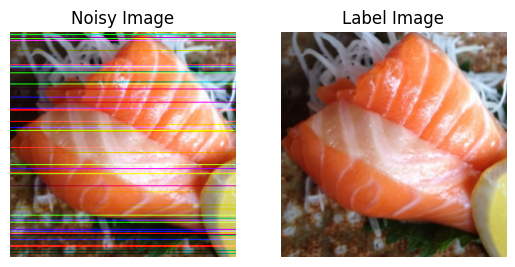

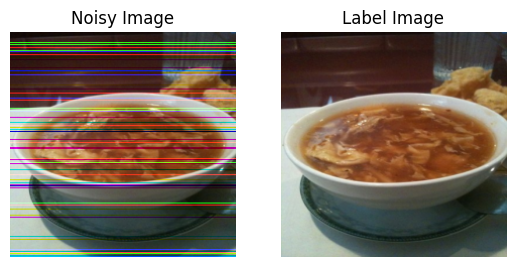

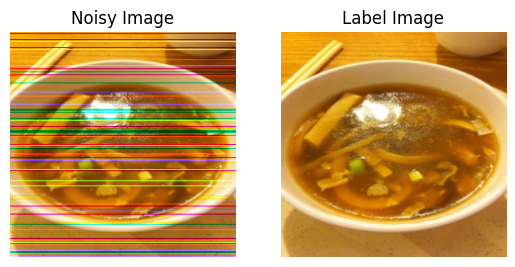

In [33]:
from torchvision.datasets import Food101
from torch.utils.data import random_split, Subset


# Define transforms for Food101 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224)
    transforms.ToTensor(),           # Convert images to tensors
])

# Load the Food101 test dataset
train_dataset = Food101(root='./data', split='test', transform=transform, download=True)

# Create a Subset of the first 1120 images
subset_indices = range(1120)
selected_train_dataset = Subset(train_dataset, subset_indices)

# Print the number of samples in the truncated dataset
print(len(train_dataset))

# Define the number of samples for training and validation
num_total_samples = len(selected_train_dataset)
num_val_samples = 120

# Calculate the number of training samples
num_train_samples = 1000


# Perform random split for the test dataset
train_dataset, val_dataset = random_split(selected_train_dataset, [num_train_samples, num_val_samples])

# Print the number of samples in the training and validation sets
print("Number of samples in the training set:", len(train_dataset))
print("Number of samples in the validation set:", len(val_dataset))

# Create separate lists for noisy images and original images in the train dataset
noisy_images_train = [add_salt_pepper_noise(image) for image, _ in selected_train_dataset]
original_images_train = [image.clone() for image, _ in selected_train_dataset]

# Combine the lists into a list of tuples for the train dataset
train_dataset = list(zip(noisy_images_train, original_images_train))

# Create separate lists for noisy images and original images in the test dataset
noisy_images_test = [add_salt_pepper_noise(image) for image, _ in val_dataset]
original_images_test = [image.clone() for image, _ in val_dataset]

# Create a validation dataset from the test dataset
val_dataset = list(zip(noisy_images_test[:-19], original_images_test[:-19]))

# Create a test dataset containing 9 images from the end of the test dataset
test_dataset = list(zip(noisy_images_test[-19:], original_images_test[-19:]))

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


# Get a batch of images from the train loader
images, labels = next(iter(train_loader))

# Plot the first three pairs of noisy images and their corresponding labels
for i in range(3):
    # Extract the ith noisy image and its corresponding label from the batch
    noisy_image = np.transpose(images[i].numpy(), (1, 2, 0))
    label_image = np.transpose(labels[i].numpy(), (1, 2, 0))

    # Plot the noisy image
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_image)
    plt.title("Noisy Image")
    plt.axis('off')

    # Plot the corresponding label image
    plt.subplot(1, 2, 2)
    plt.imshow(label_image)
    plt.title("Label Image")
    plt.axis('off')

    plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_food = UNet(in_channels=3, out_channels=3).to(device)
criterion = nn.MSELoss().to(device)

# Define optimizer
optimizer = optim.Adam(model_food.parameters(), lr=0.001)

# Training loop
best_val_loss = float('inf')
epochs = 10

for epoch in range(epochs):
    model_food.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model_food(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # Average training loss
    train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model_food.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_food(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    # Average validation loss
    val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Save the model with the best validation accuracy
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_food.state_dict(), 'best_model_food.pth')

print("Training complete.")

Epoch 1/10, Train Loss: 0.17369722872972487, Val Loss: 0.046782671704445736
Epoch 2/10, Train Loss: 0.03963646947273186, Val Loss: 0.02819130309663787
Epoch 3/10, Train Loss: 0.020550197256462916, Val Loss: 0.018299772044514665
Epoch 4/10, Train Loss: 0.01709543365452971, Val Loss: 0.016703245829385104
Epoch 5/10, Train Loss: 0.016077521789286817, Val Loss: 0.015715879489584725
Epoch 6/10, Train Loss: 0.015373132537518229, Val Loss: 0.014782732048320889
Epoch 7/10, Train Loss: 0.014125181840998785, Val Loss: 0.01375501295828288
Epoch 8/10, Train Loss: 0.012040611117013864, Val Loss: 0.010658638561052262
Epoch 9/10, Train Loss: 0.008476034392203603, Val Loss: 0.008611473494605852
Epoch 10/10, Train Loss: 0.006878010968544654, Val Loss: 0.00638701952532819
Training complete.


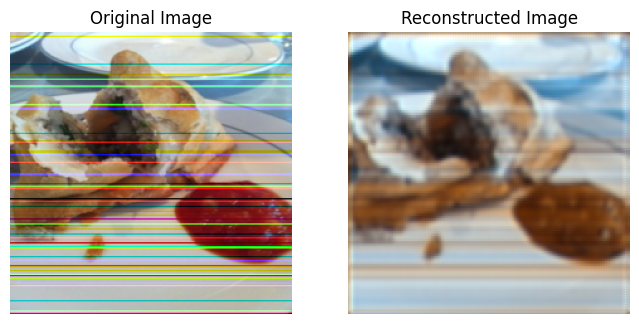

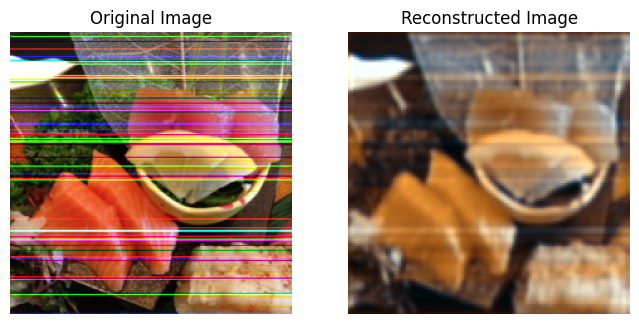

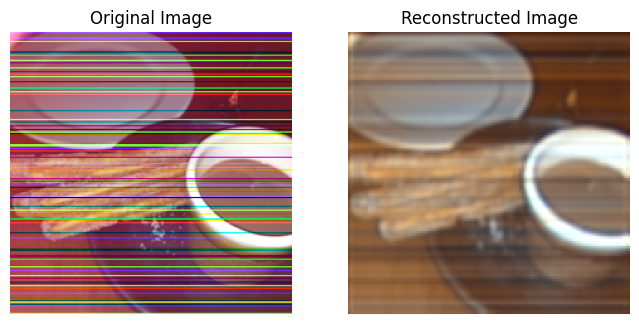

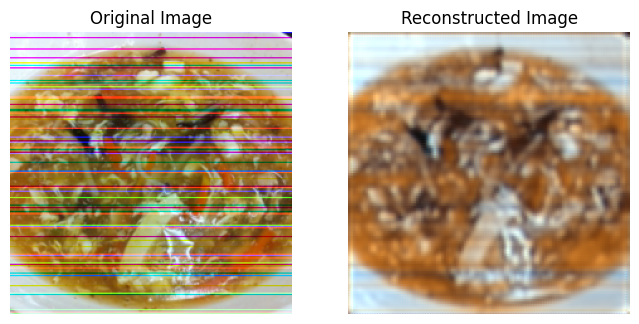

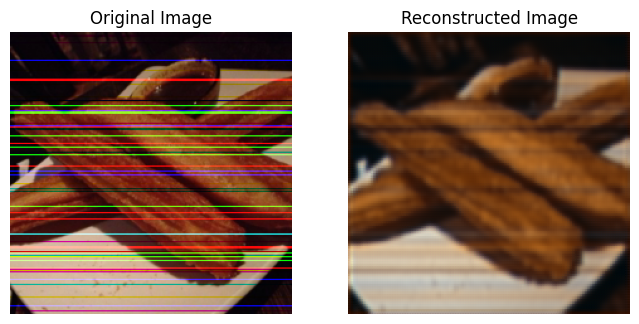

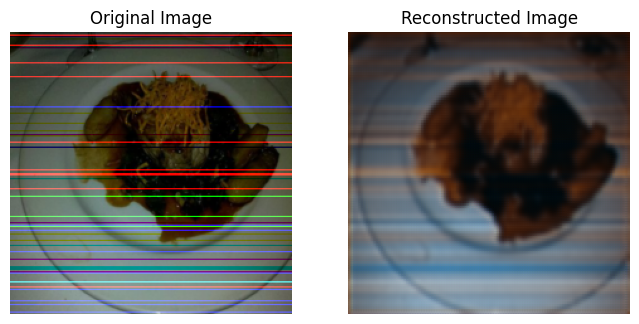

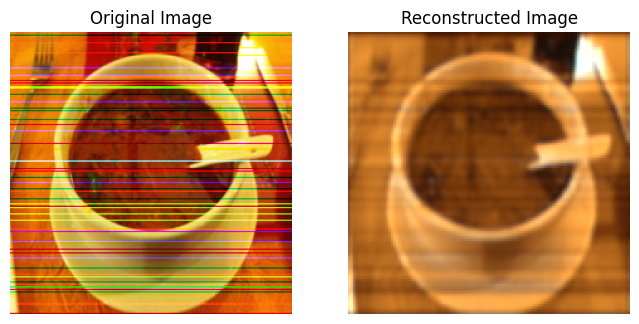

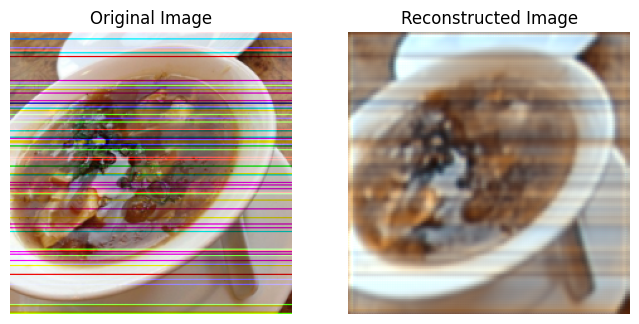

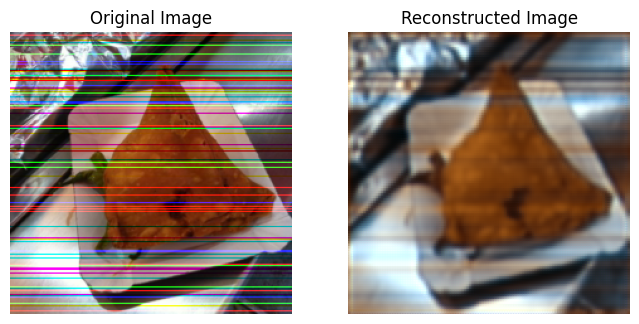

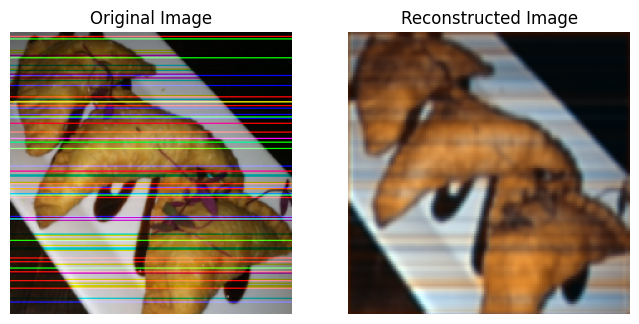

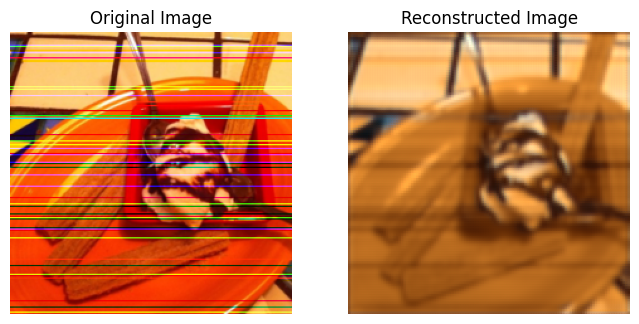

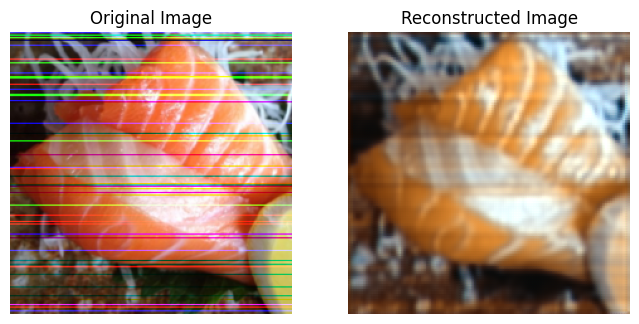

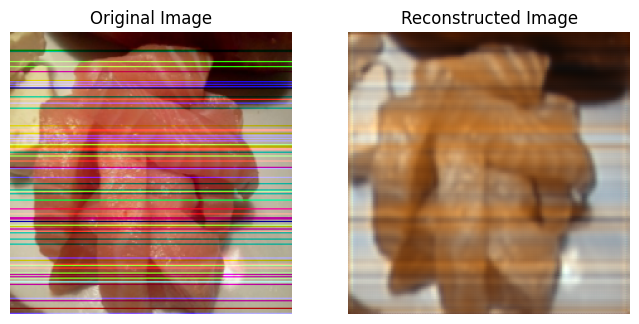

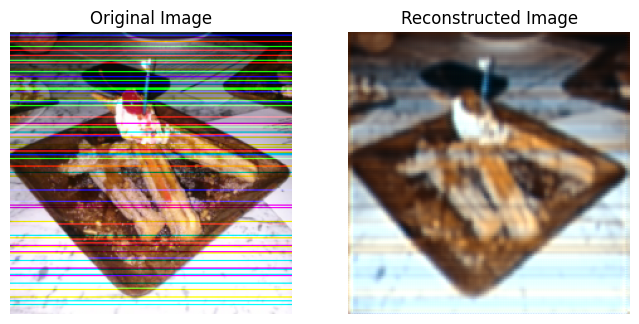

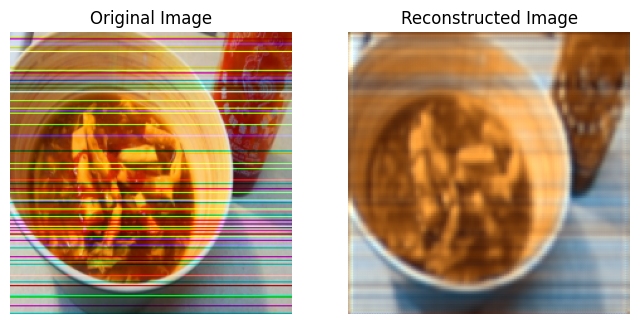

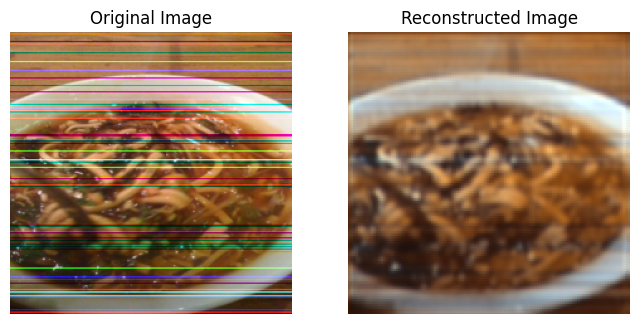

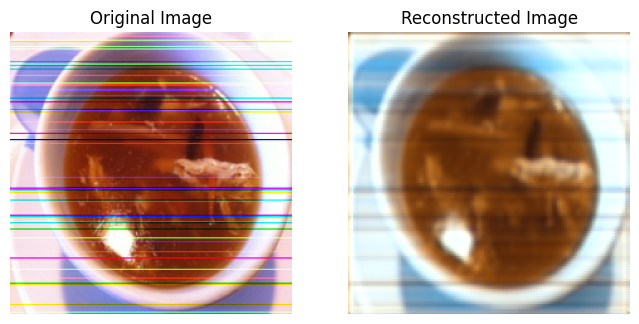

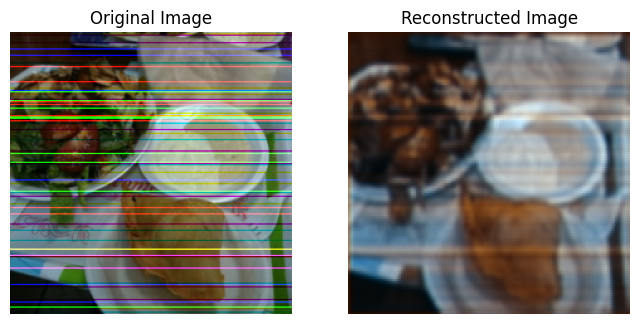

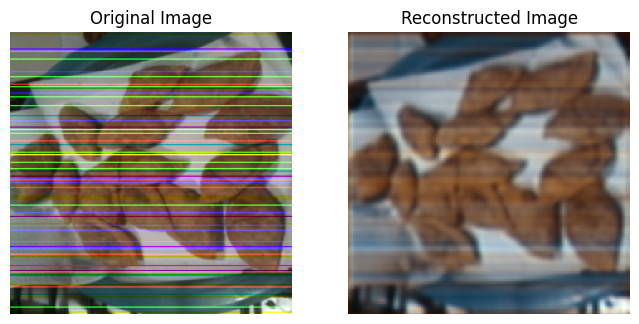

Reconstruction of test images complete.


In [39]:
# Test the model on 10 images from the validation set
model_food.load_state_dict(torch.load('best_model_food.pth'))
model_food.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_food(images)
        for i in range(outputs.size(0)):
            # Plot original and reconstructed images side by side
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            original_image = images[i].cpu().numpy().transpose(1, 2, 0)  # Transpose to (height, width, channels)
            reconstructed_image = outputs[i].cpu().numpy().transpose(1, 2, 0)  # Transpose to (height, width, channels)


            axes[0].imshow(original_image)
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            axes[1].imshow(reconstructed_image)
            axes[1].set_title("Reconstructed Image")
            axes[1].axis('off')

            plt.show()

print("Reconstruction of test images complete.")